#**Setting up libraries and loading data.**
1. The market data is loaded using drive.
2. The log file has to be manually uploaded to the colab script

In [37]:
### IMC Prosperity Visualizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from google.colab import drive
from io import StringIO

# Mount the contents from the google drive
drive.mount("/content/gdrive")
path = "/content/gdrive/MyDrive/IMC_Prosperity/"
print("Connected Successfully")

# Open and load the JSON log file.
log_path = "logfile.log"
with open(log_path, "r") as f:
    log_text = f.read()

# Split the log file into sections using the section headers.
# We assume the file contains these markers:
#   "Sandbox logs:"
#   "Activities log:"
#   "Trade History:"
#
# We use regular expressions to split the file into parts.
# (Adjust these patterns if your log file varies.)
sandbox_pattern = r"Sandbox logs:\s*(\{.*?\})\s*Trade History:"  # not used further
activities_pattern = r"Activities log:\s*(.+?)\s{2,}"  # CSV part; assume at least 2 blank lines after

# Attempt a pattern that captures "Trade History:", then a bracket, curly brace,
# any text until the matching bracket/brace, etc. Non-greedy or so.
trade_history_pattern = r"Trade History:\s*(\[\s*{.*?\])"
#                   ^ open bracket ^ open brace ... ^ close bracket
# The question mark in `.*?` means non-greedy matching, so it captures up until
# the first ] encountered. Adjust as needed for your actual log format.

# Extract Activities log portion.
activities_match = re.search(activities_pattern, log_text, flags=re.DOTALL)
if activities_match:
    activities_text = activities_match.group(1)
    # The activities text should start with the CSV header line, for example:
    # day;timestamp;product;bid_price_1;bid_volume_1;...;profit_and_loss
    print("First 200 characters of Activities log:")
    print(activities_text[:200])
else:
    raise ValueError("Activities log section not found in the log file.")

# Extract Trade History portion.
trade_history_match = re.search(trade_history_pattern, log_text, flags=re.DOTALL)
if trade_history_match:
    trade_history_text = trade_history_match.group(1)
    # Remove any trailing whitespace
    trade_history_text = trade_history_text.strip()
else:
    raise ValueError("Trade History section not found in the log file.")
# Suppose trade_history_text is your raw string extracted from the log file.
# Instead of:
#    fixed_str = re.sub(r",\s*}", "}", trade_history_text)
#    fixed_str = re.sub(r",\s*\]", "]", fixed_str)
# use these capturing-group versions:

fixed_str = re.sub(r",\s*(\})", r"\1", trade_history_text)
fixed_str = re.sub(r",\s*(\])", r"\1", fixed_str)

# For debugging, print the fixed string's first 200 characters:
print("First 200 characters of fixed version:")
print(fixed_str[:200])

# Now try to parse the fixed string as JSON:
try:
    trade_data = json.loads(fixed_str)
    print("Successfully parsed trade data!")
except json.JSONDecodeError as e:
    print("JSONDecodeError after cleaning:", e)

# Replace the file paths with your local file paths.
prices_day0 = pd.read_csv(path + "prices_round_3_day_0.csv", sep=';')
prices_day1 = pd.read_csv(path + "prices_round_3_day_1.csv", sep=';')
prices_day_2 = pd.read_csv(path + "prices_round_3_day_2.csv", sep=';')

trades_day0 = pd.read_csv(path + "trades_round_3_day_0.csv", sep=';')
trades_day1 = pd.read_csv(path + "trades_round_3_day_1.csv", sep=';')
trades_day_2 = pd.read_csv(path + "trades_round_3_day_2.csv", sep=';')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Connected Successfully
First 200 characters of Activities log:
day;timestamp;product;bid_price_1;bid_volume_1;bid_price_2;bid_volume_2;bid_price_3;bid_volume_3;ask_price_1;ask_volume_1;ask_price_2;ask_volume_2;ask_price_3;ask_volume_3;mid_price;profit_and_loss
0;
First 200 characters of fixed version:
[
  {
    "timestamp": 0,
    "buyer": "SUBMISSION",
    "seller": "",
    "symbol": "RAINFOREST_RESIN",
    "currency": "SEASHELLS",
    "price": 9999,
    "quantity": 8},
  {
    "timestamp": 0,
   
Successfully parsed trade data!


In [38]:
# Convert 'activities_text' into a DataFrame by passing through StringIO:
activities_df = pd.read_csv(StringIO(activities_text), sep=";")
print("Activities DataFrame columns:", activities_df.columns)
activities_df.head()

Activities DataFrame columns: Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
3,0,0,KELP,2028.0,30.0,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0
4,0,0,PICNIC_BASKET1,59223.0,19.0,59222.0,24.0,NaN,NaN,59234,19,59235.0,24.0,NaN,NaN,59228.5,0.0


In [39]:
try:
    trade_history_data = json.loads(fixed_str)
except json.JSONDecodeError as e:
    print(f"JSONDecodeError: {e}")
    line_no = e.lineno
    col_no = e.colno
    lines = fixed_str.split("\n")
    if 1 <= line_no <= len(lines):
        error_line = lines[line_no - 1]  # line_no is 1-based
        print("Offending line:", error_line)
        # Optionally print a bit more context:
        start_line = max(0, line_no - 3)
        end_line = min(len(lines), line_no + 2)
        snippet = "\n".join(lines[start_line:end_line])
        print("Context around the error:\n", snippet)

if 'trade_history_data' in locals():
    print(f"Number of trades: {len(trade_history_data)}")
    print("First trade item:", trade_history_data[0])

Number of trades: 59287
First trade item: {'timestamp': 0, 'buyer': 'SUBMISSION', 'seller': '', 'symbol': 'RAINFOREST_RESIN', 'currency': 'SEASHELLS', 'price': 9999, 'quantity': 8}


In [40]:
trades_df = pd.DataFrame(trade_history_data)
trades_df.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,SUBMISSION,,RAINFOREST_RESIN,SEASHELLS,9999,8
1,0,,,CROISSANTS,SEASHELLS,4322,8
2,0,,,DJEMBES,SEASHELLS,13494,3
3,200,,SUBMISSION,RAINFOREST_RESIN,SEASHELLS,10001,2
4,300,SUBMISSION,,KELP,SEASHELLS,2029,6


#**Visualizing day 0 data for all the products**

In [41]:
###############################################################################
# 4. Visualization Functions for Prices and Trades
###############################################################################
def plot_prices_subplot(prices_df: pd.DataFrame, product: str, day_label: str, ax):
    """
    Plots the bid, ask, and mid price for the specified product on the provided Axes.

    Assumptions:
      - prices_df contains a column 'product' with the product's name.
      - Best bid is taken from "bid_price_1" and best ask from "ask_price_1".
      - 'timestamp' is numeric.
    """
    # Filter rows for the specific product
    sub = prices_df[prices_df["product"] == product].copy()
    if sub.empty:
        ax.text(0.5, 0.5, f"No data for {product}", transform=ax.transAxes,
                ha="center", va="center", fontsize=12, color="red")
        ax.set_title(product)
        return

    sub.sort_values("timestamp", inplace=True)
    # Plot best bid and ask
    ax.plot(sub["timestamp"], sub["bid_price_1"], label="Bid", color="tab:blue")
    ax.plot(sub["timestamp"], sub["ask_price_1"], label="Ask", color="tab:orange")
    # Plot mid price if available
    if "mid_price" in sub.columns:
        ax.plot(sub["timestamp"], sub["mid_price"], label="Mid", color="tab:green", linestyle="--")

    ax.set_title(f"{product} Prices ({day_label})")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(fontsize=8)

def plot_trades_subplot(trades_df: pd.DataFrame, product: str, day_label: str, ax):
    """
    Plots trades for the specified product on the provided Axes.

    Assumptions:
      - trades_df contains a column 'symbol' that holds the product name.
      - Price vs. timestamp is plotted and quantity is used for point color.
    """
    # Filter rows where symbol equals product
    if "symbol" not in trades_df.columns:
        ax.text(0.5, 0.5, "No 'symbol' column in trades data", transform=ax.transAxes,
                ha="center", va="center", fontsize=12, color="red")
        ax.set_title(product)
        return
    sub = trades_df[trades_df["symbol"] == product].copy()
    if sub.empty:
        ax.text(0.5, 0.5, f"No trades for {product}", transform=ax.transAxes,
                ha="center", va="center", fontsize=12, color="red")
        ax.set_title(product)
        return

    sub.sort_values("timestamp", inplace=True)
    sc = ax.scatter(sub["timestamp"], sub["price"], c=sub["quantity"], cmap="viridis", alpha=0.8)
    ax.set_title(f"{product} Trades ({day_label})")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    plt.colorbar(sc, ax=ax, label="Quantity", )

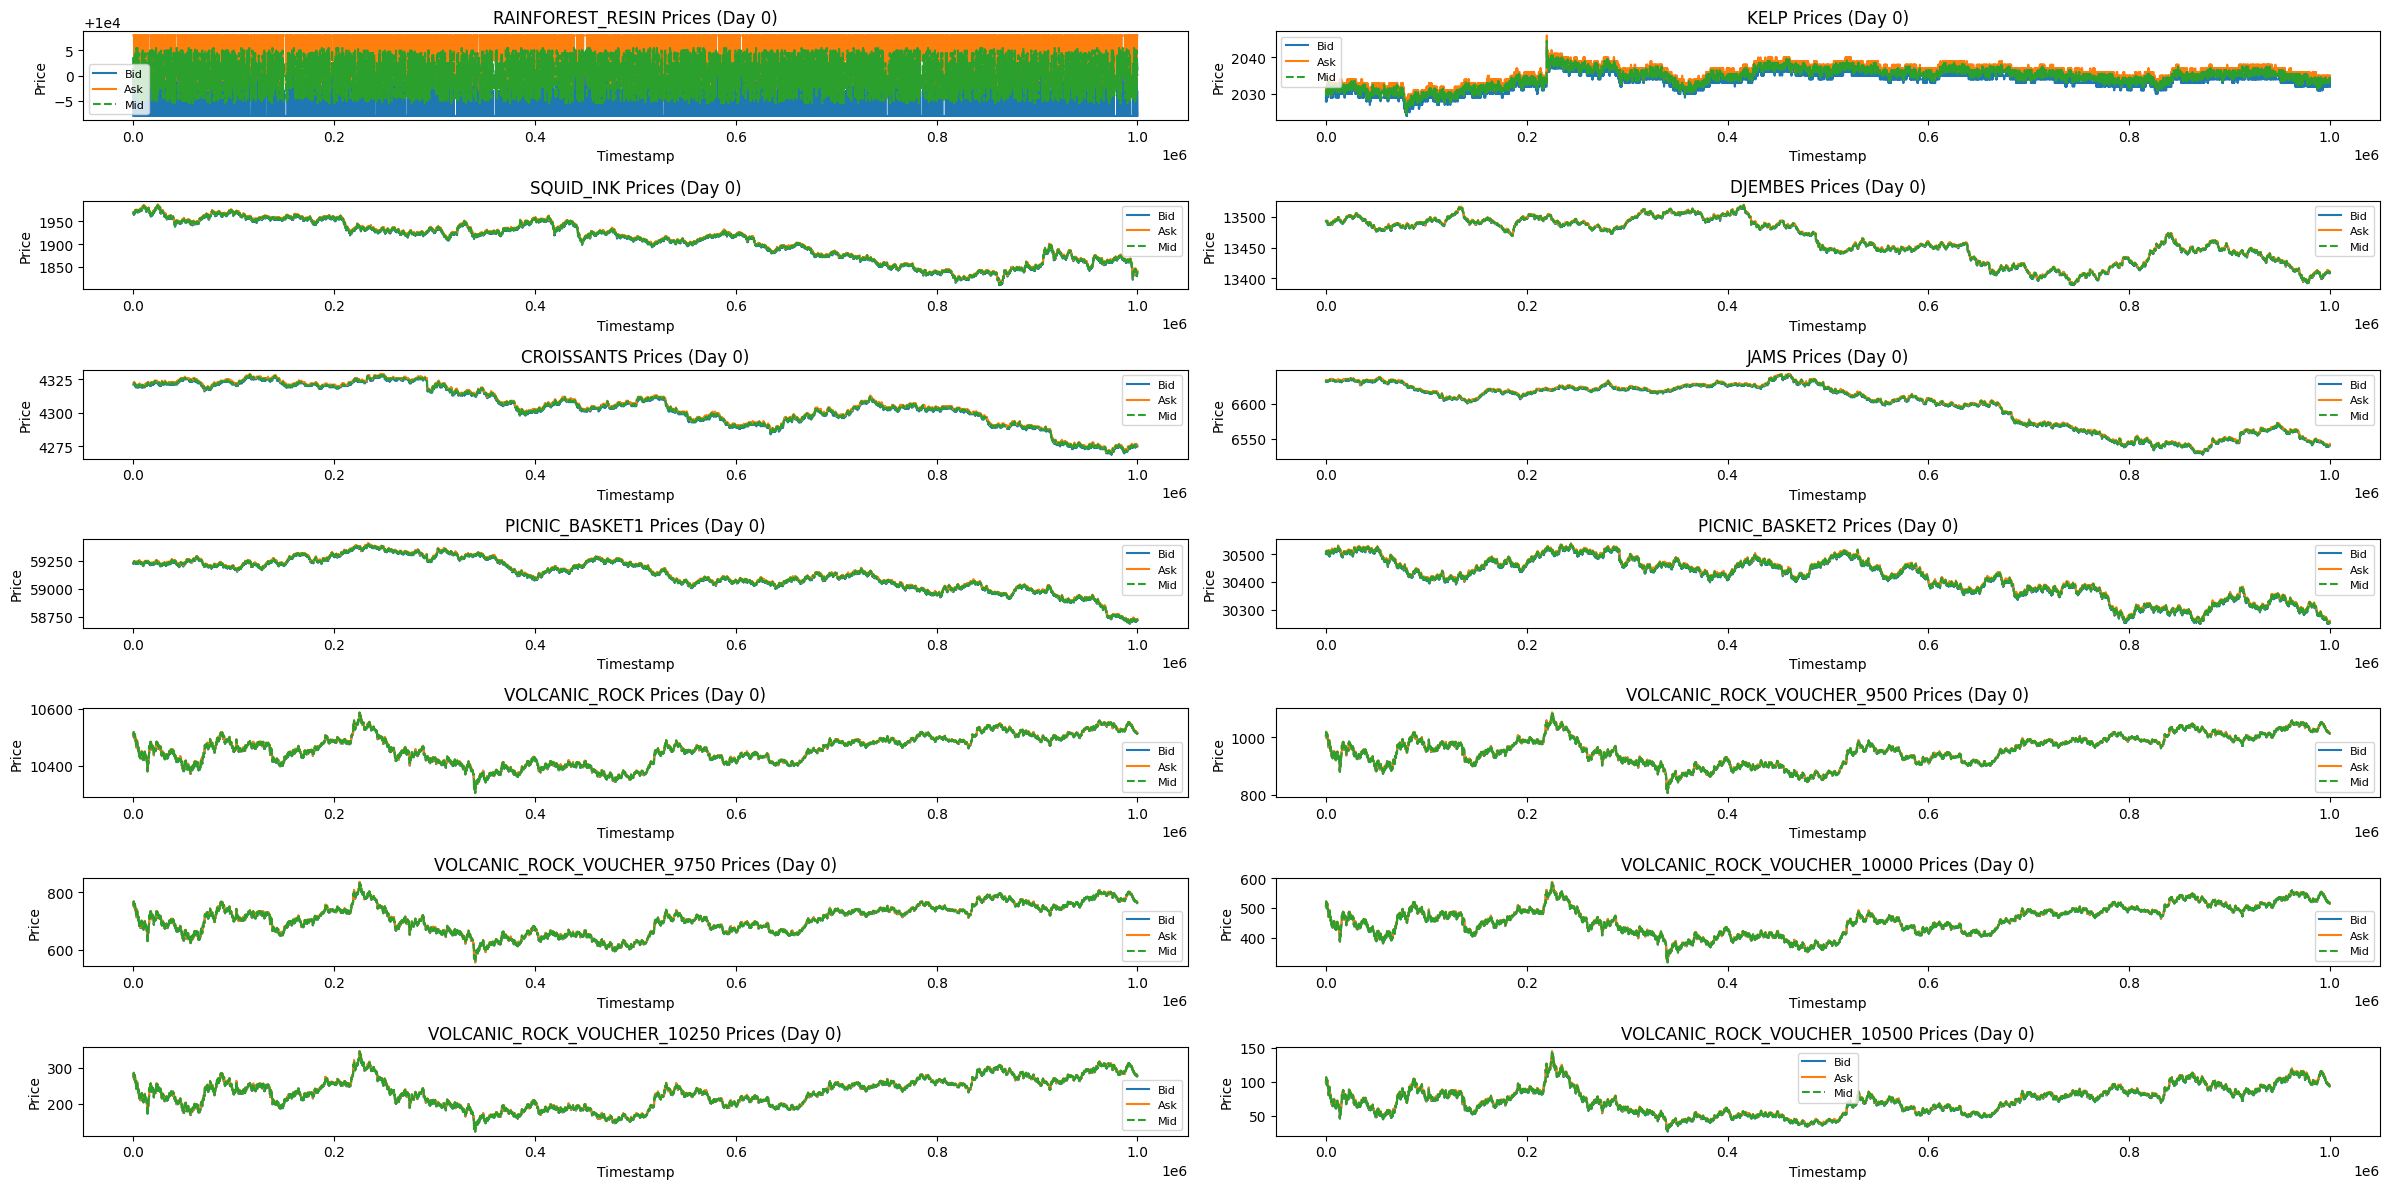

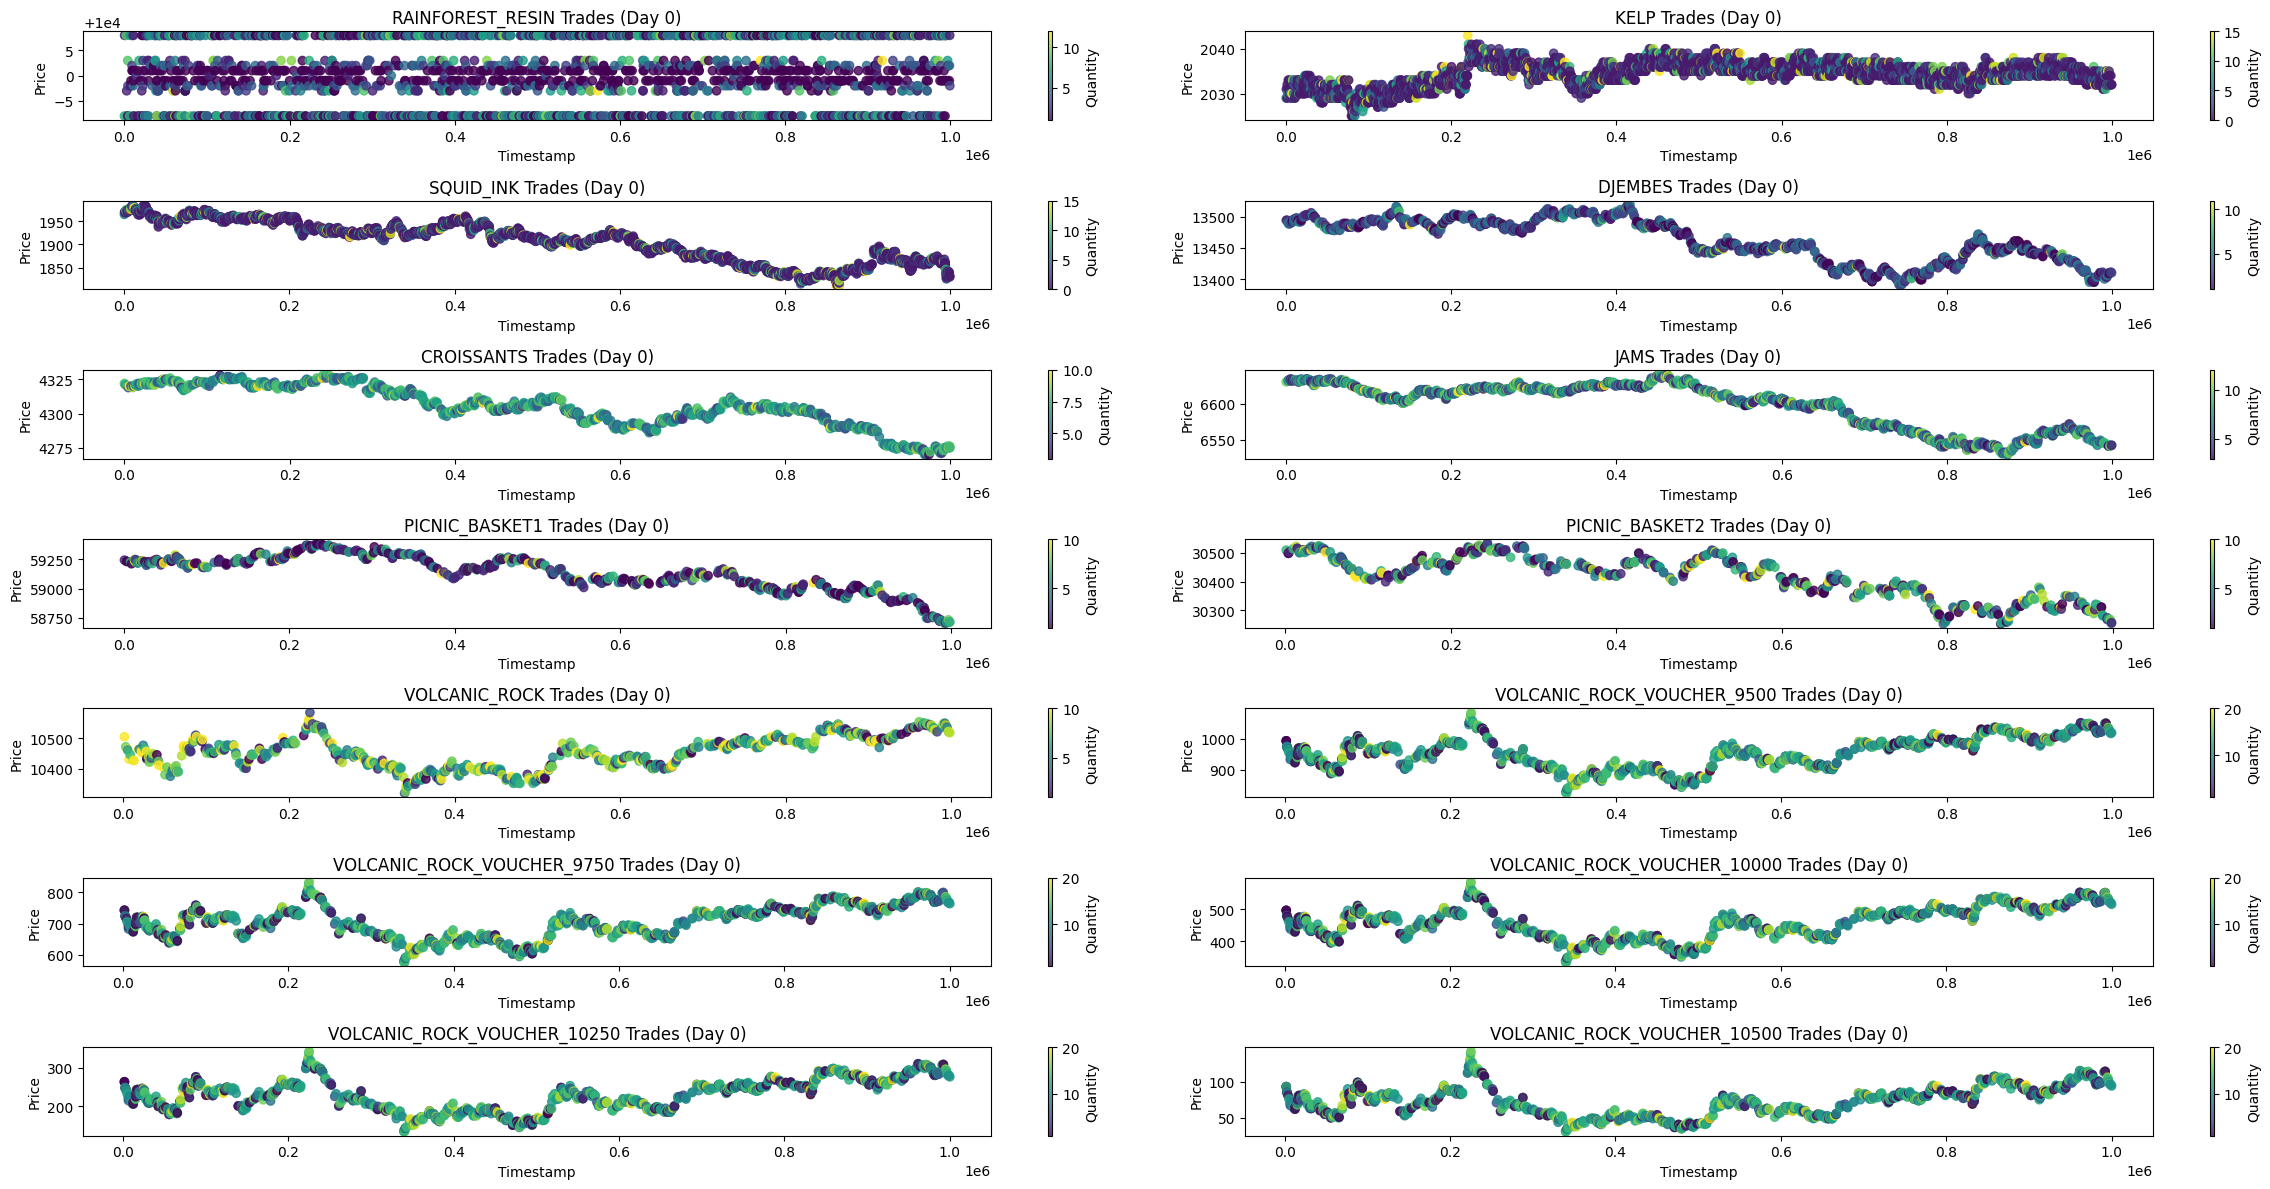

In [42]:
###############################################################################
# 5. Create Subplot Grid for Prices and Trades (Day 0 Example)
###############################################################################
products_of_interest = [
    "RAINFOREST_RESIN",
    "KELP",
    "SQUID_INK",
    "DJEMBES",
    "CROISSANTS",
    "JAMS",
    "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500",
    "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000",
    "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500",

]

# Checking for squid ink

# Define grid size for 8 products (4 rows x 2 columns)
fig_prices, axes_prices = plt.subplots(nrows=7, ncols=2, figsize=(24, 12))
axes_prices = axes_prices.flatten()

for i, prod in enumerate(products_of_interest):
    plot_prices_subplot(prices_day0, prod, "Day 0", axes_prices[i])
plt.tight_layout()
plt.show()

fig_trades, axes_trades = plt.subplots(nrows=7, ncols=2, figsize=(24, 12))
axes_trades = axes_trades.flatten()

for i, prod in enumerate(products_of_interest):
    plot_trades_subplot(trades_day0, prod, "Day 0", axes_trades[i])
plt.tight_layout()
plt.show()

#**Visualizing for squid ink**

In [43]:
##############################################################################
# 3. Filter Data for SQUID_INK
##############################################################################
# For prices, the column that identifies the product is "product"
prices_squid_0    = prices_day0[prices_day0["product"] == "SQUID_INK"].copy()
prices_squid_1    = prices_day1[prices_day1["product"] == "SQUID_INK"].copy()
prices_squid_2 = prices_day_2[prices_day_2["product"] == "SQUID_INK"].copy()

# For trades, we assume the column to check is "symbol"
trades_squid_0    = trades_day0[trades_day0["symbol"] == "SQUID_INK"].copy()
trades_squid_1    = trades_day1[trades_day1["symbol"] == "SQUID_INK"].copy()
trades_squid_2 = trades_day_2[trades_day_2["symbol"] == "SQUID_INK"].copy()

# For consistency, filter trades where symbol == "SQUID_INK for logging data"
trades_squid = trades_df[trades_df["symbol"] == "SQUID_INK"].copy()
trades_squid.sort_values("timestamp", inplace=True)

Unique days for SQUID_INK in activities log: [np.int64(0), np.int64(1), np.int64(2)]


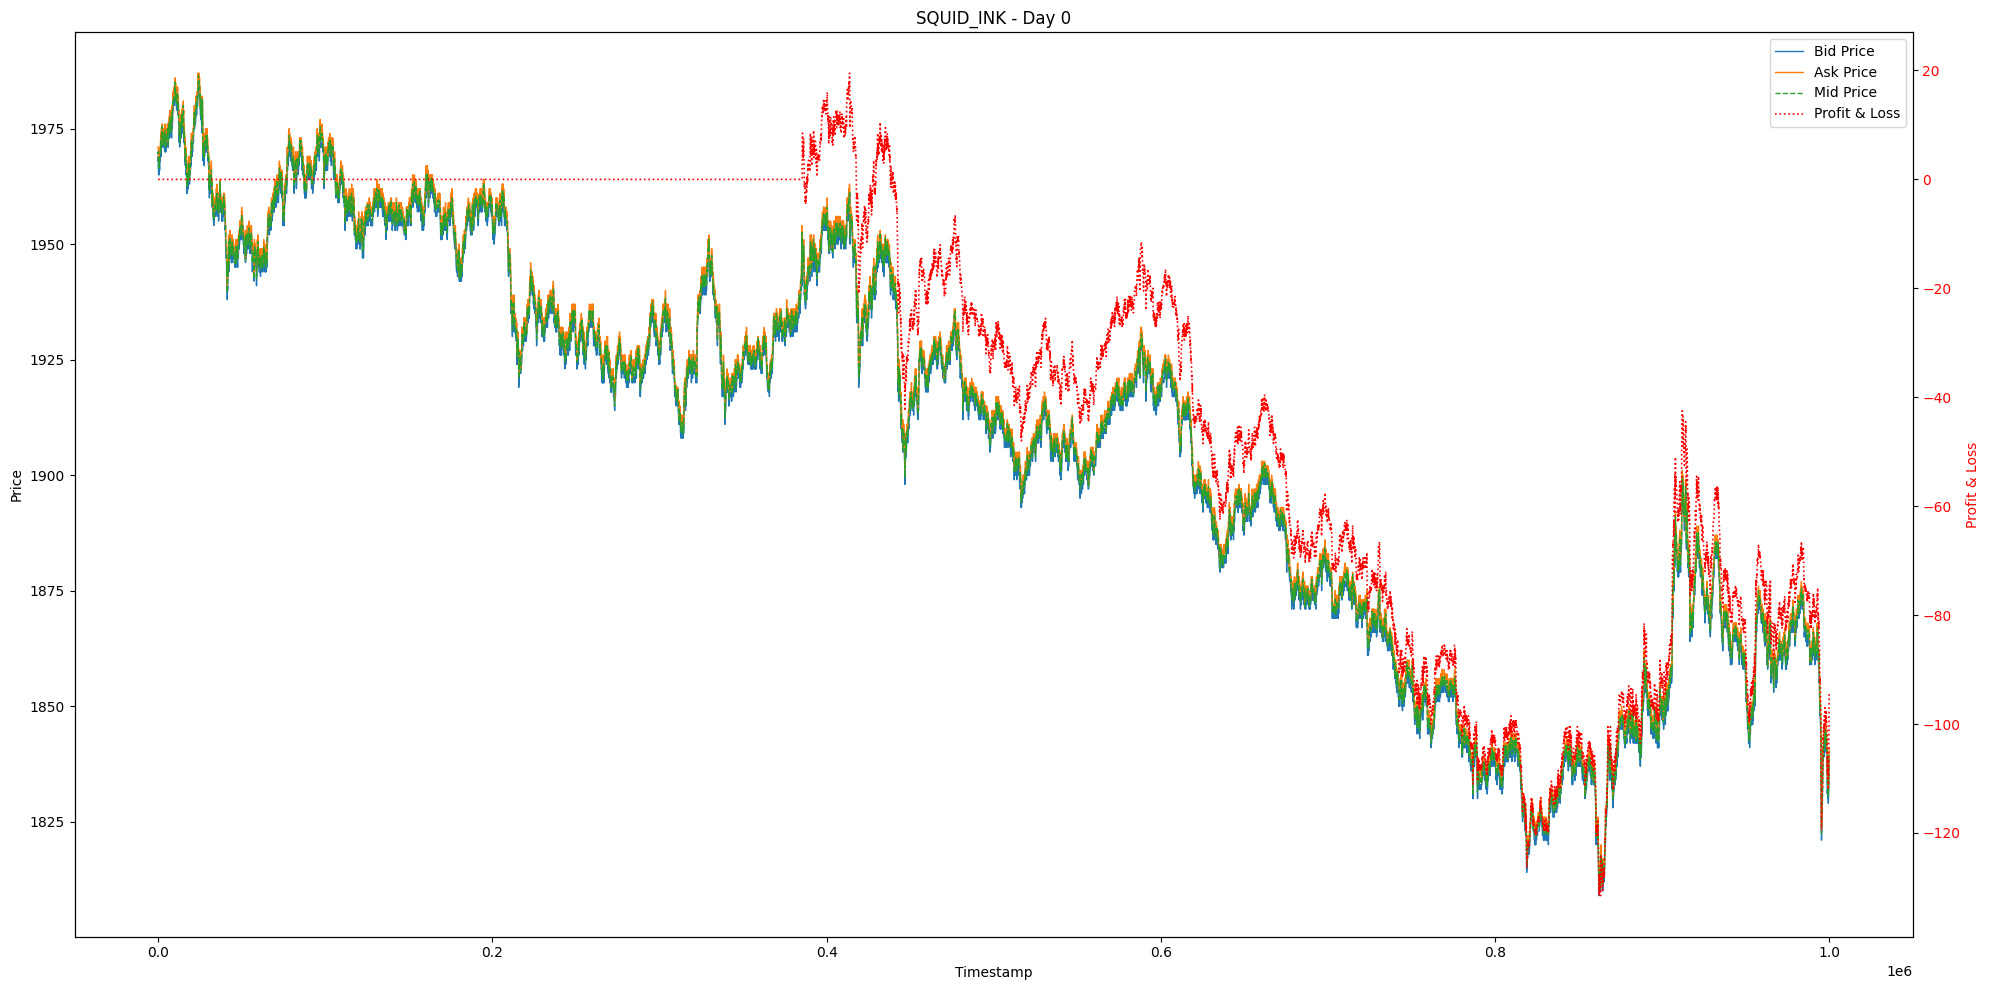

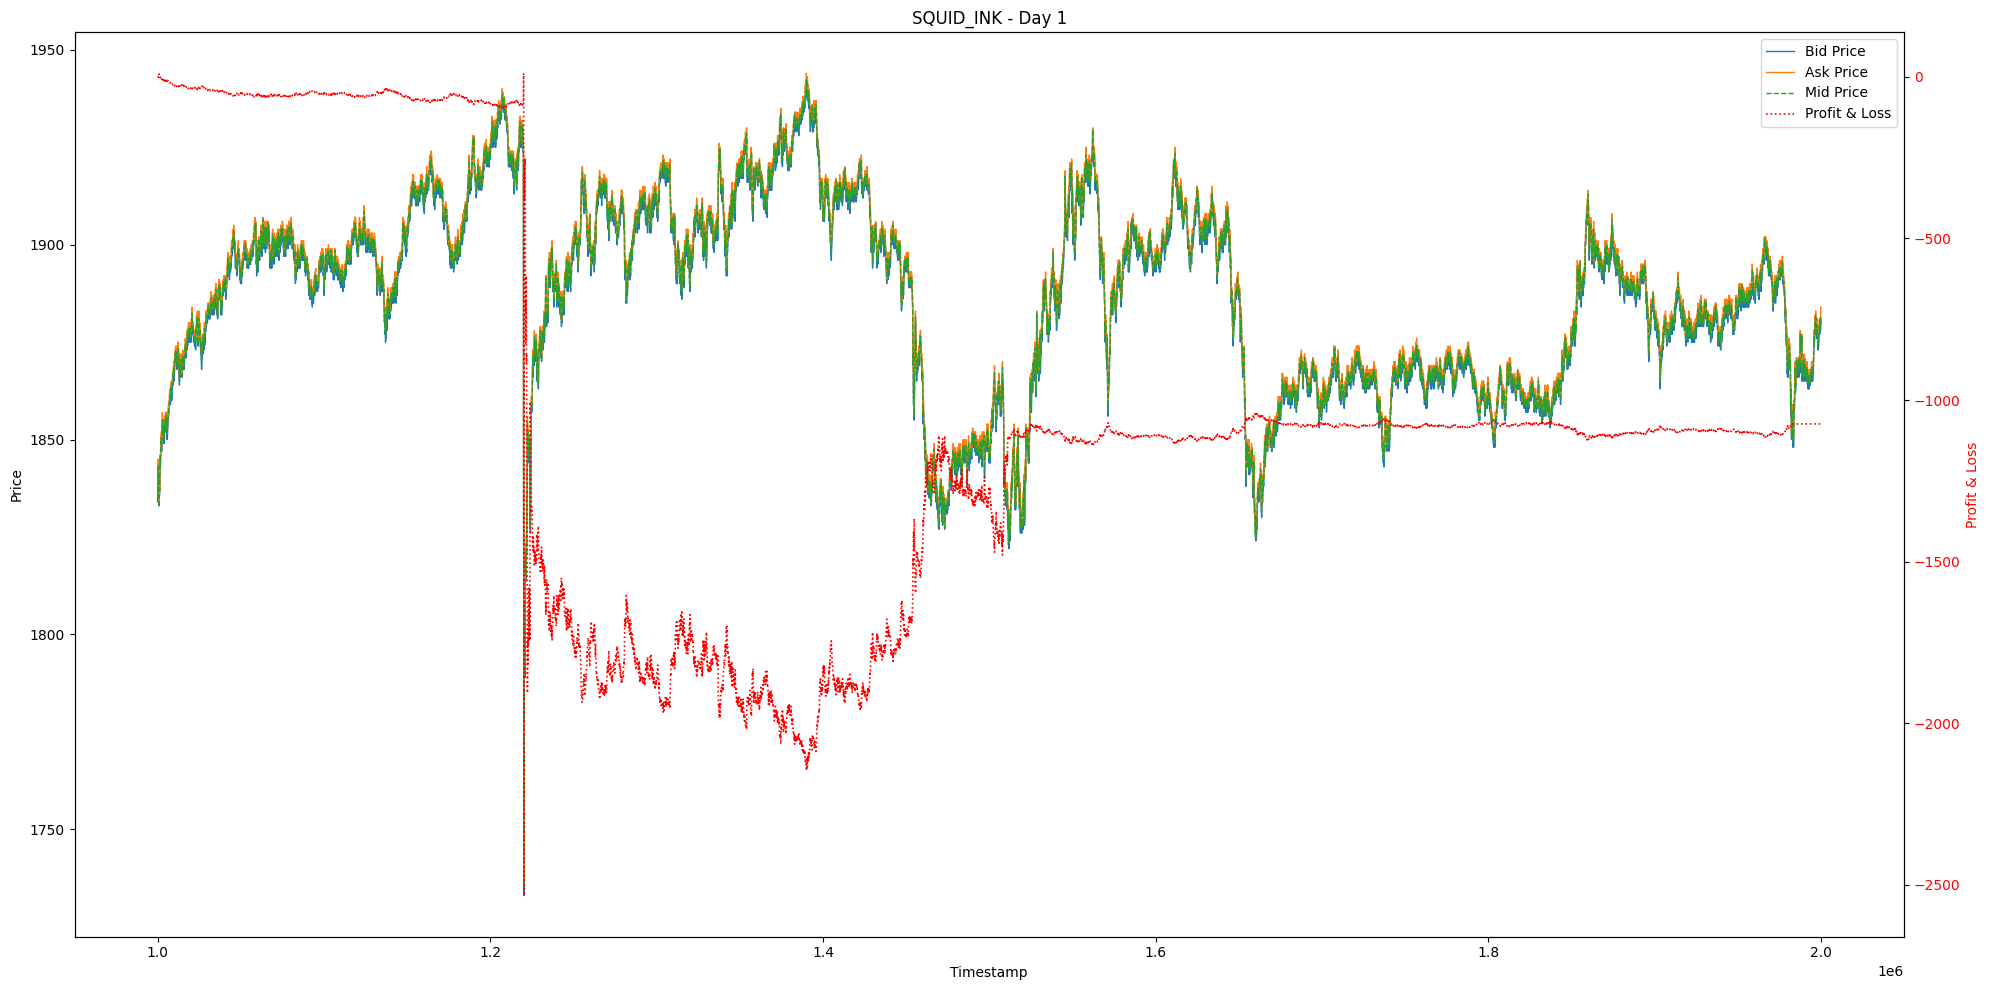

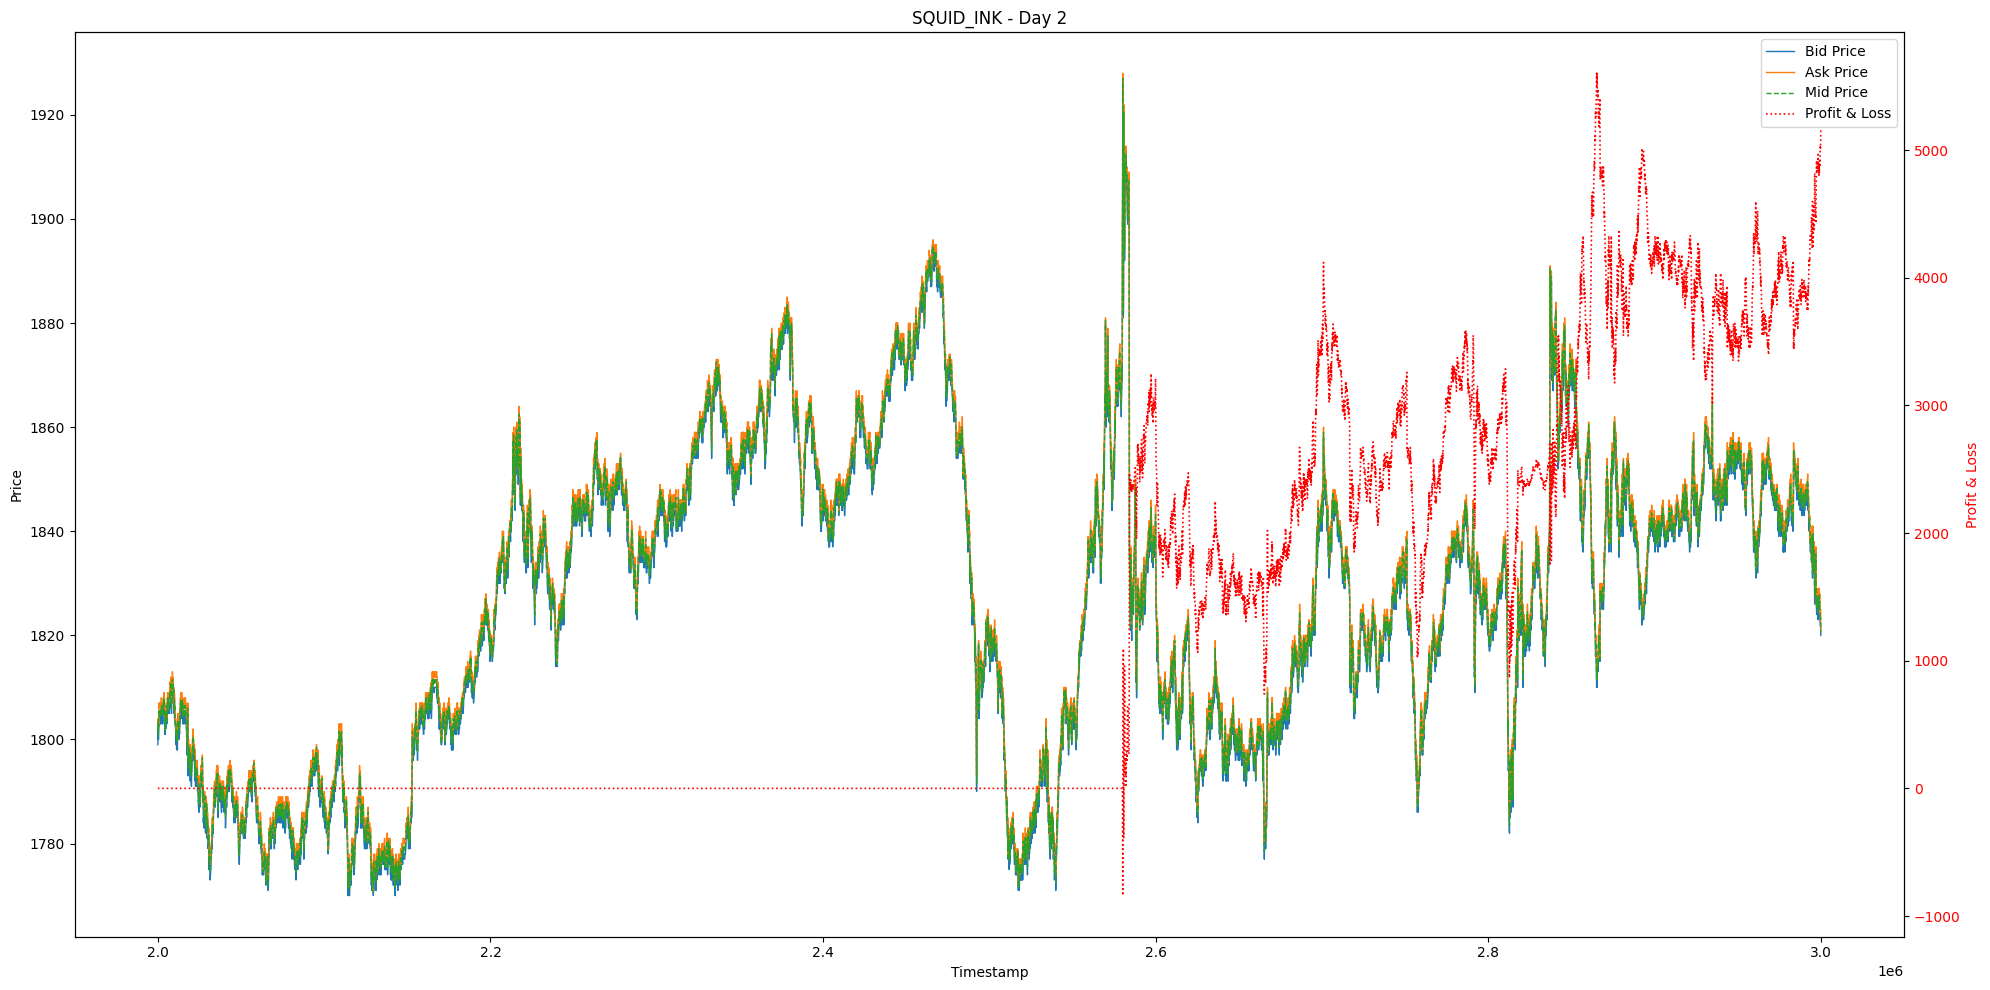

In [44]:
##############################################################################
# 3. Filter Activities Data for SQUID_INK
##############################################################################
# Your activities DataFrame has a "day" column and a "product" column.
activities_squid = activities_df[activities_df["product"] == "SQUID_INK"].copy()
activities_squid.sort_values("timestamp", inplace=True)

# Determine the unique days available for SQUID_INK.
unique_days = sorted(activities_squid["day"].unique())
print("Unique days for SQUID_INK in activities log:", unique_days)

##############################################################################
# 4. Create a function to plot a single day's data (BIGGER figure, no subplot)
##############################################################################
def plot_squid_for_day(activities_df: pd.DataFrame,
                       trades_df: pd.DataFrame,
                       day_val: int):
    """
    Creates a single figure (no subplot) with a large size for day = day_val:
    - Plots bid_price_1, ask_price_1, mid_price from activities
    - Overlays profit_and_loss if available
    - Filters trades by the day’s min/max timestamp to avoid out-of-range plotting
    - Plots trades as scatter with color for quantity
    """
    # Filter activities for the given day
    sub_act = activities_df[activities_df["day"] == day_val].copy()
    if sub_act.empty:
        print(f"No SQUID_INK market data for day {day_val}. Skipping figure.")
        return

    sub_act.sort_values("timestamp", inplace=True)
    tmin = sub_act["timestamp"].min()
    tmax = sub_act["timestamp"].max()

    # We'll also filter the trades to the timestamp range [tmin, tmax]
    # for symbol == "SQUID_INK". Adjust if you prefer a different approach.
    sub_trades = trades_df[
        (trades_df["symbol"] == "SQUID_INK") &
        (trades_df["timestamp"] >= tmin) &
        (trades_df["timestamp"] <= tmax)
    ].copy()
    sub_trades.sort_values("timestamp", inplace=True)

    fig, ax = plt.subplots(figsize=(20, 10))  # <--- bigger figure
    # Plot bid/ask/mid
    ax.plot(sub_act["timestamp"], sub_act["bid_price_1"], label="Bid Price", color="tab:blue", linewidth=1.0)
    ax.plot(sub_act["timestamp"], sub_act["ask_price_1"], label="Ask Price", color="tab:orange", linewidth=1.0)
    if "mid_price" in sub_act.columns:
        ax.plot(sub_act["timestamp"], sub_act["mid_price"], label="Mid Price", linestyle="--", color="tab:green", linewidth=1.0)

    # Overlay profit_and_loss on a second y-axis if present
    if "profit_and_loss" in sub_act.columns:
        ax2 = ax.twinx()
        ax2.plot(sub_act["timestamp"], sub_act["profit_and_loss"],
                 label="Profit & Loss", color="red", linestyle=":", linewidth=1.2)
        ax2.set_ylabel("Profit & Loss", color="red")
        ax2.tick_params(axis="y", labelcolor="red")
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=10)
    else:
        ax.legend(loc="best", fontsize=10)

    # # Scatter trades
    # if sub_trades.empty:
    #     print(f"No trades found in [timestamp={tmin}..{tmax}] for day {day_val}")
    # else:
    #     sc = ax.scatter(sub_trades["timestamp"], sub_trades["price"],
    #                     c=sub_trades["quantity"], cmap="viridis", alpha=0.7, marker="x")
    #     cbar = plt.colorbar(sc, ax=ax)
    #     cbar.set_label("Trade Quantity")

    ax.set_title(f"SQUID_INK - Day {day_val}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")

    plt.tight_layout()
    plt.show()

##############################################################################
# 5. Loop Over Each Day in unique_days, Creating One Large Figure Per Day
##############################################################################
for day_val in unique_days:
    plot_squid_for_day(activities_squid, trades_df, day_val)